# Data Storytelling - Hotel Bookings

This notebook analyzes hotel bookings from two hotels over the span of two years to identify and illustrate relevant booking trends. 

The dataset was acquired from [Kaggle](https://www.kaggle.com/mojtaba142/hotel-booking).

In [1]:
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import data

bookings = pd.read_csv('data/hotel_booking.csv')
bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

## Data Wrangling

In [3]:
# Remove cancellations

bookings = bookings[bookings['is_canceled'] == 0].reset_index()

In [4]:
# Fill null values in the children column with 0

bookings['children'].fillna(value=0, inplace=True)

In [5]:
# Calculate total number of guests

bookings['total_guests'] = pd.Series(dtype='int')

for i in np.arange(len(bookings)):
    bookings.loc[i, 'total_guests'] = bookings['adults'][i] + bookings['children'][i] + bookings['babies'][i]

In [6]:
# Convert arrival dates into datetime objects

bookings['arrival_date'] = pd.Series(dtype='datetime64[ns]')

for i in np.arange(len(bookings)):
    day = str(bookings['arrival_date_day_of_month'][i])
    month = str(bookings['arrival_date_month'][i])
    year = str(bookings['arrival_date_year'][i])
    date_string = ' '.join([day, month, year])
    bookings.loc[i, 'arrival_date'] = datetime.strptime(date_string, "%d %B %Y")

bookings['arrival_date']

0       2015-07-01
1       2015-07-01
2       2015-07-01
3       2015-07-01
4       2015-07-01
           ...    
75161   2017-08-30
75162   2017-08-31
75163   2017-08-31
75164   2017-08-31
75165   2017-08-29
Name: arrival_date, Length: 75166, dtype: datetime64[ns]

In [7]:
# Drop first couple months from the dataset so that there is an equal representation of each month across the two years

bookings = bookings[bookings['arrival_date'] > '2015-08-31'].reset_index()
bookings['arrival_date']

0       2015-09-01
1       2015-09-01
2       2015-09-01
3       2015-09-01
4       2015-09-01
           ...    
71353   2017-08-30
71354   2017-08-31
71355   2017-08-31
71356   2017-08-31
71357   2017-08-29
Name: arrival_date, Length: 71358, dtype: datetime64[ns]

In [8]:
# Convert reservation status dates into datetime objects

bookings['reservation_status_date'] = pd.to_datetime(bookings.reservation_status_date)
bookings['reservation_status_date']

0       2015-09-04
1       2015-09-04
2       2015-09-04
3       2015-09-05
4       2015-09-05
           ...    
71353   2017-09-06
71354   2017-09-07
71355   2017-09-07
71356   2017-09-07
71357   2017-09-07
Name: reservation_status_date, Length: 71358, dtype: datetime64[ns]

In [9]:
# Calculate length of stay

bookings['length_of_stay'] = pd.Series(dtype='int')

for i in np.arange(len(bookings)-1):
    bookings.loc[i, 'length_of_stay'] = abs(bookings['reservation_status_date'][i] - bookings['arrival_date'][i]).days

In [10]:
# Select necessary columns

df = bookings[['hotel', 'total_guests', 'lead_time', 'arrival_date', 'arrival_date_month',
               'arrival_date_year', 'reservation_status', 'reservation_status_date', 'length_of_stay']]
df.head()

,hotel,total_guests,lead_time,arrival_date,arrival_date_month,arrival_date_year,reservation_status,reservation_status_date,length_of_stay
0,Resort Hotel,2.0,48,2015-09-01,September,2015,Check-Out,2015-09-04,3.0
1,Resort Hotel,2.0,48,2015-09-01,September,2015,Check-Out,2015-09-04,3.0
2,Resort Hotel,3.0,27,2015-09-01,September,2015,Check-Out,2015-09-04,3.0
3,Resort Hotel,4.0,50,2015-09-01,September,2015,Check-Out,2015-09-05,4.0
4,Resort Hotel,2.0,122,2015-09-01,September,2015,Check-Out,2015-09-05,4.0


## Data Exploration

To look at the booking trends over time, the total number of bookings, the average length of stay, and the average time booked in advance will be calculated for each month of each year.

In [11]:
# Creating a dataset of bookings per month

month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
num_bookings = df.groupby(['arrival_date_year', 'arrival_date_month']).count()[['hotel']]
averages = df.groupby(['arrival_date_year', 'arrival_date_month']).mean().loc[:,['lead_time', 'length_of_stay']]
bookings_per_month = num_bookings.join(averages).rename(columns={"hotel":"bookings",
                                                                  "lead_time":"avg_lead_time",
                                                                  "length_of_stay":"avg_stay"}).reset_index()
for i in np.arange(len(bookings_per_month)):
    month = str(bookings_per_month['arrival_date_month'][i])
    year = str(bookings_per_month['arrival_date_year'][i])
    date_string = ' '.join([month, year])
    bookings_per_month.loc[i, 'arrival_date_month_year'] = date_string
    bookings_per_month.loc[i, 'arrival_date'] = datetime.strptime(date_string, "%B %Y")

bookings_per_month.set_index('arrival_date', inplace=True)
bookings_per_month.sort_values(by='arrival_date', inplace=True)
bookings_per_month

,arrival_date_year,arrival_date_month,bookings,avg_lead_time,avg_stay,arrival_date_month_year
arrival_date,,,,,,
2015-09-01,2015,September,3020,75.623841,3.653974,September 2015
2015-10-01,2015,October,3225,65.189457,3.104496,October 2015
2015-11-01,2015,November,1854,39.799892,3.170442,November 2015
2015-12-01,2015,December,1947,38.725732,2.928608,December 2015
2016-01-01,2016,January,1691,20.138380,2.504435,January 2016
2016-02-01,2016,February,2554,26.624511,2.760767,February 2016
2016-03-01,2016,March,3347,42.221990,3.071407,March 2016
2016-04-01,2016,April,3367,65.636769,3.128304,April 2016
2016-05-01,2016,May,3563,94.985125,3.266629,May 2016


Taking a look at the number of bookings per month over time below, there appears to be a consistent seasonal trend where business drops off during the months of November, December, and January but picks up throughout the rest of the year.

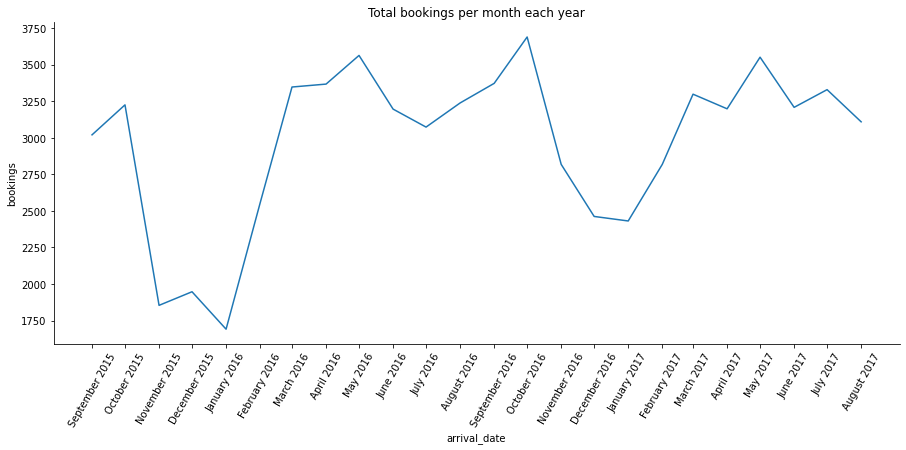

In [12]:
# How many bookings are there over time?

b = sns.relplot(x='arrival_date', y="bookings", data=bookings_per_month, kind='line', aspect=5/2)
b.set(xticks=bookings_per_month.index)
b.set_xticklabels(labels=bookings_per_month['arrival_date_month_year'], rotation=60)
plt.title('Total bookings per month each year')
plt.show(b)

The plot below also illustrates the seasonal fluctuations in the amount of bookings. May and October seem to be the most popular months at these hotels. As mentioned above, the winter season is the least popular time of year to book a reservation.

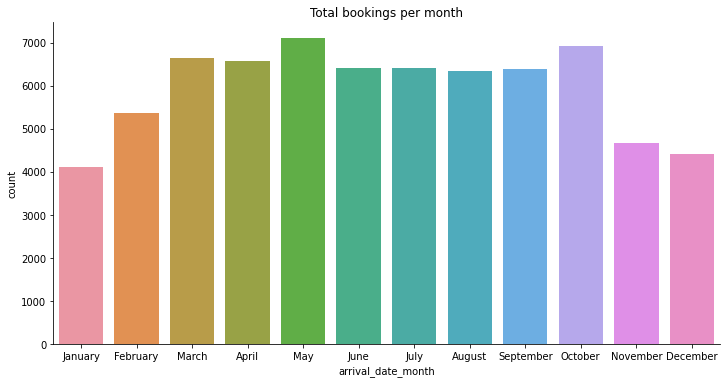

In [13]:
# How many bookings are there per month?

sns.catplot(x='arrival_date_month', data=df, order=month_order, kind='count', aspect=2/1)
plt.title('Total bookings per month')
plt.show()

#### Length of Stay

A large majority of the bookings are for less than one week.

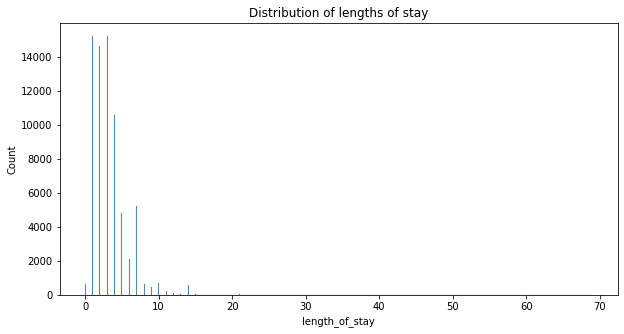

count    71357.000000
mean         3.352453
std          2.544722
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         69.000000
Name: length_of_stay, dtype: float64

In [14]:
# How long do people stay?

plt.figure(figsize=(10,5))
sns.histplot(x='length_of_stay', data=df)
plt.title('Distribution of lengths of stay')
plt.show()
df.length_of_stay.describe()

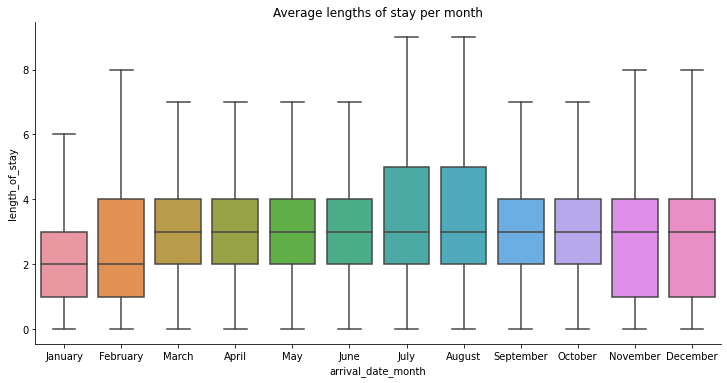

length_of_stay       
                             mean median
arrival_date_month                      
April                    3.319878    3.0
August                   3.876300    3.0
December                 3.020186    3.0
February                 2.938943    2.0
January                  2.749151    2.0
July                     3.811153    3.0
June                     3.609151    3.0
March                    3.282318    3.0
May                      3.318527    3.0
November                 3.153896    3.0
October                  3.154180    3.0
September                3.585263    3.0

In [15]:
# How long are the average lengths of stay per month?

month_order=['January', 'February', 'March', 'April', 'May', 'June',
             'July', 'August', 'September', 'October', 'November', 'December']

sns.catplot(x='arrival_date_month', y='length_of_stay', data=df,
            order=month_order, kind='box', showfliers=False, aspect=2/1)
plt.title('Average lengths of stay per month')
plt.show()
df.groupby('arrival_date_month').agg(['mean', 'median'])[['length_of_stay']]

#### Time Booked in Advance

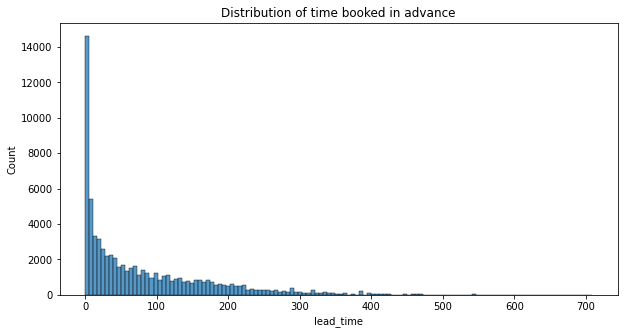

count    71358.000000
mean        80.793758
std         91.926895
min          0.000000
25%          9.000000
50%         46.000000
75%        126.000000
max        709.000000
Name: lead_time, dtype: float64

In [16]:
# How long do people book in advance?

plt.figure(figsize=(10,5))
sns.histplot(x='lead_time', data=df)
plt.title('Distribution of time booked in advance')
plt.show()
df.lead_time.describe()

More people book farther in advance for the summer months than they do for the rest of the year.

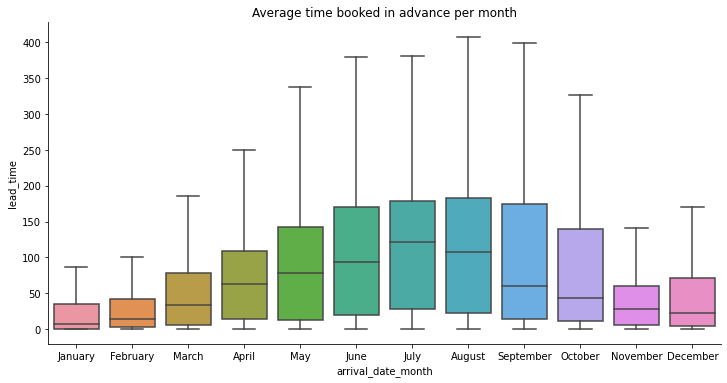

lead_time       
                          mean median
arrival_date_month                   
January              26.644590      8
February             32.585257     14
March                53.033108     34
April                75.026047     63
May                  96.114985     78
June                110.535915     94
July                125.460169    121
August              115.461793    107
September           102.981852     60
October              90.785797     44
November             44.652611     28
December             48.359492     23

In [17]:
# How long do people book in advance per month?

sns.catplot(x='arrival_date_month', y='lead_time', data=df,
            order=month_order, kind='box', showfliers=False, aspect=2/1)
plt.title('Average time booked in advance per month')
plt.show()
df.groupby('arrival_date_month').agg(['mean', 'median'])[['lead_time']].reindex(index=month_order)

#### Feature Relationships

The average length of stay and the average time booked in advance per month is highly correlated. The total number of bookings is also moderately correlated to the average length of stay and the average time booked in advance.

In [18]:
bookings_per_month[['bookings', 'avg_stay', 'avg_lead_time']].reset_index(drop=True).corr()

,bookings,avg_stay,avg_lead_time
bookings,1.000000,0.578411,0.698957
avg_stay,0.578411,1.000000,0.838584
avg_lead_time,0.698957,0.838584,1.000000


## Conclusion

Certain times of the year seem to be more desirable for people to book a stay at these hotels. The total number of bookings per month show that there is a steady rate of business during the spring, summer, and fall while the winter is the least busy time of year. This might be explained by the fact that November, December, and January are times of the year where many people visit family for the holidays or simply because it is often colder than it is during other months of the year. People also tend to book farther out in advance during the busier months. Intuitively, it makes sense that the average length of stay and average time booked in advance are highly correlated because if people are bookings longer stays at the hotels, there will be less flexibility in availability and people will have to adjust by planning ahead sooner. Furthermore, the fact that the total number of bookings per month is correlated to these two metrics suggests that more people decide to stay longer during busier times of the year and are therefore booking farther in advance. Based on the number of bookings, lengths of stay, and time booked in advance, it is clear that the spring, summer, and fall attract the most guests while the winter is the least desirable time of the year for people to book a stay.